# Problem Definition
I seek correlation between sleep data and exercise data.

Sleep and exercise data extracted from Garmin Connect using GarminDB


# 1. Data Acquisition


# 2. Data Cleaning and Preprocessing

In [ ]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Make the graphs a bit prettier and bigger
plt.style.use('ggplot')

In [ ]:
files = ['Raw_Data/Raw Data in CSV/DailySummary.csv', 
         'Raw_Data/Raw Data in CSV/DailySleepSummary.csv']

# Read CSV files into dataframes
df_daily_summary = pd.read_csv(files[0])
df_daily_sleep_summary = pd.read_csv(files[1])

# Print columns of dataframes
print(df_daily_summary.columns)
print(df_daily_sleep_summary.columns)

# Drop unnecessary columns
unnecessary_columns_for_daily_summary = ['weight_avg', 'weight_min', 'weight_max', 'calories_goal', 'steps_goal', 'floors_goal', 
                       'sleep_min', 'sleep_max', 'rem_sleep_min', 'rem_sleep_max', 'calories_bmr_avg', 
                       'calories_goal', 'calories_consumed_avg', 'activities', 'activities_calories', 'activities_distance', 
                       'hydration_goal', 'hydration_avg', 'hydration_intake', 'sweat_loss', 'sweat_loss_avg', 'spo2_avg', 
                       'spo2_min','rr_waking_avg', 'rr_min', 'rr_max', 'bb_max', 'bb_min', 'inactive_hr_avg', 'inactive_hr_min',
                       'inactive_hr_max', 'hr_min', 'intensity_time_goal', 'rhr_avg', 'rhr_min', 'rhr_max', 'vigorous_activity_time']  

df_daily_summary.drop(columns=unnecessary_columns_for_daily_summary, inplace=True)

unnecessary_columns_for_daily_sleep_summary = ['avg_spo2', 'avg_rr']
df_daily_sleep_summary.drop(columns=unnecessary_columns_for_daily_sleep_summary, inplace=True)

# Change column names
new_column_names = {
    'sleep_avg': 'total_sleep',
    'rem_sleep_avg': 'rem_sleep',
    'stress_avg': 'stress',
    'calories_avg': 'calories',
    'calories_active_avg': 'calories_active',
    'awake' : 'awake_duration',
    'start' : 'start_time',
    'end' : 'end_time',
    'intensity_time' : 'intensity_duration',
    'moderate_activity_time' : 'moderate_activity_duration',
}

df_daily_summary.rename(columns=new_column_names, inplace=True)

new_column_names_2 = {
    'avg_stress': 'stress',
    'awake' : 'awake_duration',
    'start' : 'start_time',
    'end' : 'end_time'
}

df_daily_sleep_summary.rename(columns=new_column_names_2, inplace=True)

print("\nAfter changes, the columns of the dataframes are: ")
print(df_daily_summary.columns)
print(df_daily_sleep_summary.columns)

In [ ]:
# Make sure 'day' is the index in both dataframes
df_daily_summary.set_index('day', inplace=True)
df_daily_sleep_summary.set_index('day', inplace=True)

# Combine dataframes and fill null values
merged_df = df_daily_summary.combine_first(df_daily_sleep_summary)

# Reset index
merged_df.reset_index(inplace=True)

# Sort by day
merged_df.sort_values(by='day', inplace=True)

# Drop the first row
merged_df = merged_df.drop(merged_df.index[0])

# Drop the rows without qualifier value
merged_df = merged_df.dropna(subset=['qualifier'])

print("After changes, the columns:")
print(merged_df.columns)
print(merged_df.head()) 

## Outlier Detection and Handling
- Handle negative stress values
- Impute with mean values of corresponding column

In [ ]:
# OUTLIER DETECTION AND HANDLING

# Outlier calculating using IQR method
def calculate_outliers(df):
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=[np.number])

    # Calculate Q1, Q3, and IQR on numeric columns
    Q1 = numeric_cols.quantile(0.25)
    Q3 = numeric_cols.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    # Create a list to store the outlier information
    outlier_info = []

    # Iterate over each column
    for col in numeric_cols.columns:
        # Identify outliers in this column
        col_outliers = (numeric_cols[col] < (Q1[col] - 1.5 * IQR[col])) | (numeric_cols[col] > (Q3[col] + 1.5 * IQR[col]))
        # Add outlier information to the list
        for row in col_outliers[col_outliers].index:
            outlier_info.append({'row': row, 'column': col, 'value': numeric_cols.loc[row, col]})

    # Convert the list to a DataFrame
    outlier_info = pd.DataFrame(outlier_info)

    return outlier_info

outlier_info = calculate_outliers(merged_df)
#print(outlier_info)

In [ ]:
# Negative STRESS values are due to error -> replace with mean

# Create a boolean mask for rows with outliers
outlier_rows = merged_df.index.isin(outlier_info['row'])

# Calculate the mean of the non-outlier 'STRESS' values
mean_stress = merged_df.loc[~outlier_rows, 'stress'].mean()

# Replace the negative 'STRESS' values in the outliers with the mean
merged_df.loc[outlier_rows & (merged_df['stress'] < 0), 'stress'] = mean_stress

# Replace outliers with the median of the column
for index, row in outlier_info.iterrows():
    merged_df.loc[row['row'], row['column']] = merged_df[row['column']].median()

# Update the outliers 
outlier_info = calculate_outliers(merged_df)

# Now print the DataFrame
print(outlier_info)

### Handle time duration values

In [ ]:
duration_cols = ['awake_duration', 'rem_sleep', 'total_sleep', 'deep_sleep', 'light_sleep', 'intensity_duration', 'moderate_activity_duration']

# Convert each column to timedelta
for column in duration_cols:
    merged_df[column] = pd.to_timedelta(merged_df[column], errors='coerce')

print("\nAfter converting to timedelta:")
print(merged_df.head(1))

### Handling date values by converting into datetime object

In [ ]:
merged_df['day'] = pd.to_datetime(merged_df['day'])
merged_df['start_time'] = pd.to_datetime(merged_df['start_time'])
merged_df['end_time'] = pd.to_datetime(merged_df['end_time'])

### Handle missing numeric values

In [ ]:
# Display the number of missing values in each column
print(merged_df.isnull().sum())

# Handle numeric missing values by filling with the mean of respective columns
numeric_columns = merged_df.select_dtypes(include=[np.number]).columns.tolist()
merged_df[numeric_columns] = merged_df[numeric_columns].fillna(merged_df[numeric_columns].mean())

print("\nAfter handling missing values:")

if merged_df.isnull().sum().sum() == 0:
    print("No missing values in the DataFrame after handling missing values")
else :
    print("Missing values still exist in the DataFrame after handling missing values")
    print(merged_df.isnull().sum())

# 3. Exploratory Data Analysis (EDA)

## Feature Engineering
Derive new features
- active ratio
- stress_level: Refer to [this website](https://www.garmin.com.my/minisite/garmin-technology/health-science/stress-tracking/#:~:text=A%20score%20from%20zero%20to,to%20keep%20stress%20in%20check) for categorization choice
- steps_level
- day_of_week
- 7-day moving average

In [ ]:
# Feature engineering: New features
# Active Ratio
merged_df['active_ratio'] = merged_df['calories_active'] / merged_df['calories']

# Stress Level Categories
merged_df['stress_level'] = pd.cut(merged_df['stress'], bins=[0, 25, 50, 75, 100], labels=['Rest', 'Low', 'Medium', 'High'])

# Steps Level
merged_df['steps_level'] = pd.cut(merged_df['steps'], bins=[0, 2500, 5000, 7500, 10000, np.inf], labels=['Sedentary', 'Lightly Active', 'Active', 'Very Active', 'Super Active'])

# Day of the Week
# 'day' is in the format 'YYYY-MM-DD'
merged_df['day_of_week'] = pd.to_datetime(merged_df['day']).dt.day_name()

# Calculate the 7-day moving average
merged_df['7_day_avg'] = merged_df['score'].rolling(window=7).mean()
# Order the days of the week
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

average_7_day_avg = merged_df.groupby('day_of_week')['7_day_avg'].mean().reindex(ordered_days)

#print(merged_df.head(1))

print(merged_df['stress_level'].value_counts())
print(merged_df['steps_level'].value_counts())
print(merged_df['day_of_week'].value_counts())

In [ ]:
# List of columns for activeness
activeness_features = ['calories', 'calories_active', 'steps', 'floors', 'intensity_duration_mins', 'moderate_activity_duration_mins']

# List of columns for the second correlation
sleep_features = ['light_sleep_mins', 'deep_sleep_mins', 'rem_sleep_mins', 'total_sleep_mins', 'score', 'qualifier']

## Global Properties of the Dataset

In [ ]:
print(merged_df.info())

In [ ]:
print("\nSummary statistics of numeric values:")
print(merged_df.describe())

## Distribution of features

### Normalize the dataset

In [ ]:
# List of timedelta columns
print(merged_df[duration_cols].dtypes)

for col in duration_cols:
    merged_df[col + '_mins'] = merged_df[col].dt.total_seconds() / 60

print("\nAfter adding _mins columns:")
print(merged_df.head(1))

# Initialize a scaler
scaler = MinMaxScaler()

# Create a new DataFrame for the normalized columns
normalized_df = merged_df.copy()

# List of numerical columns
num_cols = ['calories', 'calories_active', 'floors', 'hr_avg', 'hr_max', 'score', 'steps', 'stress']

# List of columns to normalize
cols_to_normalize = num_cols + [t + '_mins' for t in duration_cols]

# Normalize the columns
normalized_df[cols_to_normalize] = scaler.fit_transform(normalized_df[cols_to_normalize])

print("\nAfter normalization:")
print(normalized_df.head(1))

### Distribution of numerical features

In [ ]:
# Define a list of pairs of columns to be plotted together
column_pairs = [
    ['awake_duration_mins', 'rem_sleep_mins', 'total_sleep_mins', 'deep_sleep_mins', 'light_sleep_mins'],
    ['moderate_activity_duration_mins', 'intensity_duration_mins']
]

# Define titles for each plot
titles = [
    'Sleep Phases Density',
    'Activity Duration Density'
]

# Define colors for each column
colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow']

# Plot active calorie expenditure distribution
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Box plot
sns.boxplot(x=normalized_df['calories_active'], color='blue', ax=axs[0])
# Histogram
sns.histplot(normalized_df['calories_active'], kde=True, color='red', ax=axs[1])
# Common title
plt.suptitle('Active Calorie Expenditure Distribution')
plt.tight_layout()
plt.show()

# Plot steps distribution
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Box plot
sns.boxplot(x=normalized_df['steps'], color='blue', ax=axs[0])
# Histogram
sns.histplot(normalized_df['steps'], kde=True, color='red', ax=axs[1])
# Common title
plt.suptitle('Step Count Distribution')
plt.tight_layout()
plt.show()

for pair, title in zip(column_pairs, titles):
    plt.figure(figsize=(10, 5))
    for col, color in zip(pair, colors):
        data = normalized_df[col]
        if pair == ['awake_duration_mins', 'rem_sleep_mins', 'total_sleep_mins', 'deep_sleep_mins', 'light_sleep_mins']:
            sns.kdeplot(data, color=color, label=col.capitalize())
        else:
            sns.histplot(data, kde=True, color=color, label=col.capitalize())
    plt.title(title)
    plt.legend(title='Columns')
    plt.show()

### Distribution of sleep start and end times

In [ ]:
# Plotting datetime columns as histograms
plt.figure(figsize=(10, 5))

# Define colors for each column
colors = ['blue', 'red']

# Plotting datetime columns as histograms
datetime_cols = ['start_time', 'end_time']
for col, color in zip(datetime_cols, colors):
    sns.histplot(normalized_df[col].dt.hour, kde=True, bins=24, color=color, label=col.capitalize())  # Plot histogram of the hour of the day

plt.xlabel('Hour of the Day')
plt.title('Histogram of Start and End Hours')
plt.legend(title='Sleep Time')
plt.show()

### Distribution of sleep quality

In [ ]:
merged_df['day'] = pd.to_datetime(merged_df['day'])
merged_df.set_index('day', inplace=True)

merged_df['score'].plot(figsize=(10, 6))
plt.title('Sleep Score Over Time')
plt.show()

# Calculate the 7-day moving average
merged_df['7_day_avg'] = merged_df['score'].rolling(window=7).mean()

In [ ]:
# Plotting categorical columns
sns.countplot(x='qualifier', data=normalized_df)
plt.title('Sleep Quality Distribution') 
plt.xticks(rotation=90)
plt.show()

## Exploring which days of the week I sleep better & weekly sleep fluctuation
**Finding**:
- It turns out I have a pretty average weekly sleep score of an approximate 80
- From Monday to Tuesday a steep decrease is observed
- From Friday to weekend a steep increase is observed

In [ ]:
# Calculate the average sleep score for each day of the week
average_scores = merged_df.groupby('day_of_week')['score'].mean()

average_scores = average_scores.reindex(ordered_days)

# Create a bar plot of the average sleep scores
ax = average_scores.plot(kind='bar', figsize=(10, 6), alpha=0.5, color='b')

# Create a line plot of the 7-day moving average
ax2 = average_7_day_avg.plot(kind='line', marker='o', secondary_y=True, ax=ax)

ax.set_xlabel('') # Hide x-axis label
ax2.set_yticklabels([]) # Hide y-axis labels on secondary y-axis
ax2.set_yticks([]) # Hide y-axis ticks on secondary y-axis
plt.title('Average Sleep Score and 7-Day Moving Average by Day of the Week')
plt.show()

## Exploring correlation between stress level and sleep score

In [ ]:
# Assuming 'stress' and 'score' are columns in your DataFrame
sns.regplot(x='stress', y='score', data=normalized_df)
plt.show()

# Calculate the correlation matrix
correlation_matrix = normalized_df[['stress', 'score']].corr()
print(correlation_matrix)

## Exploring correlation between stress level and physical activity

### Encode stress_level feature

In [ ]:


# Create a label encoder
le = LabelEncoder()

# Encode 'stress' and 'stress_level'
normalized_df['stress_encoded'] = le.fit_transform(normalized_df['stress'])
normalized_df['stress_level_encoded'] = le.fit_transform(normalized_df['stress_level'])

# Add 'stress_encoded' and 'stress_level_encoded' to the list of features
features = ['stress_encoded', 'stress_level_encoded'] + activeness_features

# Calculate the correlation matrix
correlation_matrix = normalized_df[features].corr()

# Print the correlation of 'stress_encoded' and 'stress_level_encoded' with each feature
print(correlation_matrix[['stress_encoded', 'stress_level_encoded']])

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Encoded Stress Level and Activeness Features')
plt.show()

In [ ]:
# Create a label encoder
le = LabelEncoder()

# Encode 'stress_level'
normalized_df['stress_level_encoded'] = le.fit_transform(normalized_df['stress_level'])

# Add 'stress_level_encoded' to the list of features
features = ['stress_level_encoded'] + activeness_features

# Calculate the correlation matrix
correlation_matrix = normalized_df[features].corr()

# Print the correlation of 'stress_level_encoded' with each feature
print(correlation_matrix['stress_level_encoded'])

In [ ]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

## Exploring correlation between sleep features and sleep quality

**Aim**:
- To understand how sleep data are consistent with each other
- Correlation between deep sleep, REM sleep, total sleep, score, and start time. 

**Techniques used:**
- Label encoding is applied to handle string values before seeking correlation

**Finding**:
- Sleep score and sleep durations influence sleep quality positively 
- However, deep sleep duration has low correlation 

In [ ]:
# Initialize a label encoder
le = LabelEncoder()

# Fit the label encoder with the 'qualifier' column
le.fit(normalized_df['qualifier'])

# Define the mapping
# reverse the mapping
qualifier_mapping = {'INVALID': 0, 'POOR': 1, 'FAIR': 2, 'GOOD': 3, 'EXCELLENT': 4}
# reverse

# Apply the mapping to the 'qualifier' column
normalized_df['qualifier'] = normalized_df['qualifier'].map(qualifier_mapping)

# Print the unique values in the 'qualifier' column to verify
print(normalized_df['qualifier'].unique())

# Print the unique values and their encoding
for value, encoding in qualifier_mapping.items():
    print(f'{value}: {encoding}')
    
# Print the unique values in the 'qualifier' column of normalized_df that are not in the qualifier_mapping dictionary
print(set(normalized_df['qualifier'].unique()) - set(qualifier_mapping.keys()))

In [ ]:
corr2 = normalized_df[sleep_features].corr()

# Plot the correlation matrix for the second set of columns
plt.figure(figsize=(10, 8))
sns.heatmap(corr2, annot=True, cmap='coolwarm')
plt.title('Correlation between Sleep Features and Sleep Quality')
plt.show()

## Exploring correlation between activeness and sleep quality
**Aim:**
- To understand the correlation between activeness and the quality of sleep.
- Specifically, correlation between calories, active calories, average heart rate, maximum heart rate, steps, steps level, floors, intensity time, moderate activity time, and the qualifier. This will help us understand how daily activity levels (activeness) correlate with sleep quality.

**Techniques used:**
- Label encoding is applied to handle string values before seeking correlation
- Kendall's Tau for correlation calculation 
- It is proved that complex ML models such as DecisionTree, RandomForest have low accuracy due to small data size

**Finding:**
- Surprisingly, activeness has slight negative impact on sleep quality and duration 

### Correlation for each feature using **Pearson's Correlation Coefficient** method

In [ ]:
# Combine two lists
corr_list = activeness_features + sleep_features

# Calculate the correlation matrix for the first set of columns
corr1 = normalized_df[corr_list].corr()

# Plot the correlation matrix for the first set of columns
plt.figure(figsize=(10, 8))
sns.heatmap(corr1, annot=True, cmap='coolwarm')
plt.title('Correlation between Activeness Metrics and Sleep Quality')
plt.show()

### Correlation between activeness and sleep score

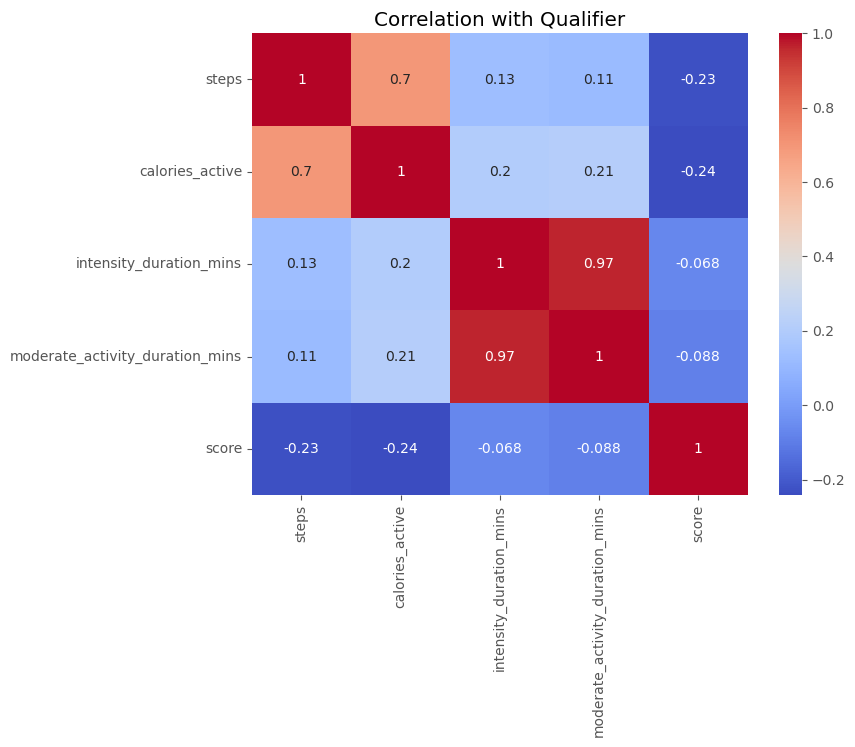

In [35]:
corr_with_qualifier = normalized_df[['steps', 'calories_active', 'intensity_duration_mins', 'moderate_activity_duration_mins', 'score']].corr()

#print("Correlation with qualifier:")
#print(corr_with_qualifier)

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_with_qualifier, annot=True, cmap='coolwarm')
plt.title('Correlation with Qualifier')
plt.show()

### Further analysis of the relationship between activeness and sleep quality using a **decision tree model**

In [ ]:
# Define the feature columns and the target column
feature_cols = ['steps', 'calories_active', 'intensity_duration_mins', 'moderate_activity_duration_mins', 'deep_sleep_mins']
target_col = 'qualifier'

# Split the data into training and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(merged_df[feature_cols], merged_df[target_col], test_size=0.2, random_state=42, stratify=merged_df[target_col])

# Create and fit the decision tree model
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

# Make predictions on the test set and calculate the accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Define the parameter grid
param_grid = {'max_depth': range(1, 10)}

# Create the grid search object
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')

# Fit the grid search object to the data
grid.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

### Correlation between activeness and sleep start time

Using **Pearson's Correlation Coefficient**. Why choose this method?
- SRC does not assume datasets are normally distributed
- Can be used when the relationship is not linear

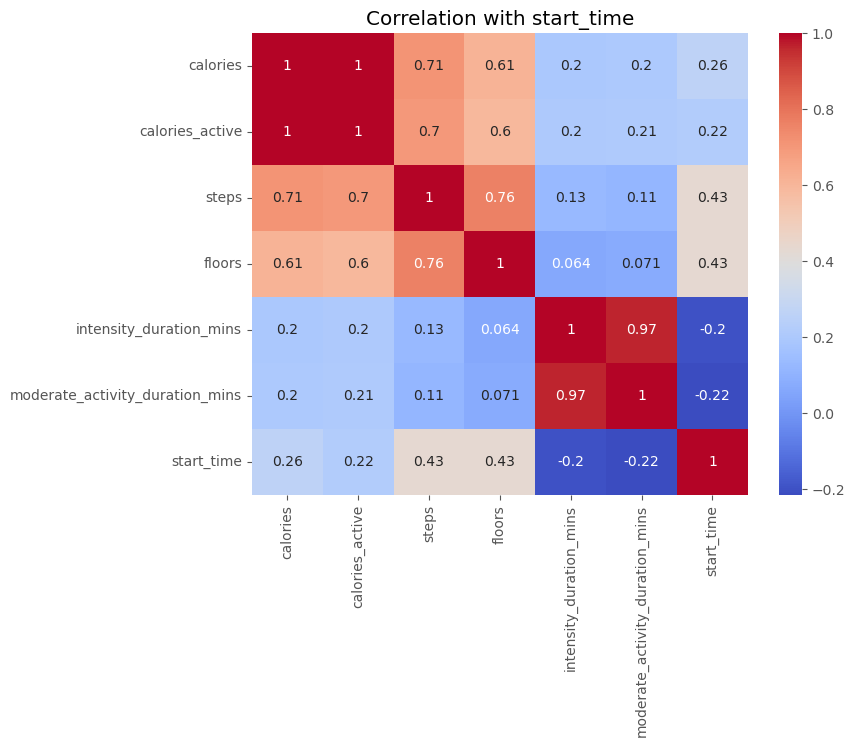

In [39]:
corr_with_start_time = normalized_df[activeness_features + ['start_time']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_with_start_time, annot=True, cmap='coolwarm')
plt.title('Correlation with start_time')
plt.show()

# Hypothesis Testing and Statistical Analysis

## Sleep duration ~ Sleep quality
**Null hypothesis:** There is no correlation between sleep duration and sleep quality

In [ ]:
correlation, p_value = pearsonr(normalized_df['total_sleep_mins'], normalized_df['score'])

print(f'Correlation: {correlation}')
print(f'P-value: {p_value}')

### Hypothesis testing
Using Pearson correlation test, 
- Correlation: 0.6300386664844899
- p-value: 7.461805108064072e-24
### Conclusion
p-value is extremelly small. Hence, assuming there is no actual corrolation, the probability of observing such strong correlation by chance is extremely low.

Null hypothesis can be rejected. This correlation is statistically significant provides strong evidence for an alternative hypothesis that **as sleep duration increases, sleep quality also increases**.

## Active calorie burned ~ Sleep score
**Null hypothesis:** There's no correlation between active calorie burned and sleep score

In [37]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(normalized_df['calories_active'], normalized_df['score'])

print(f'Correlation: {correlation}')
print(f'P-value: {p_value}')

Correlation: -0.24184153456526303
P-value: 0.0005086136505719167


### Hypothesis testing
Using Pearson correlation test, 
- Correlation: -0.24184153456526303
- p-value: 0.0005086136505719167

### Conclusion
The p-value is extremely small (=< 0.05). Assuming no correlation, this strong correlation cannot occur by chance.

Null hypothesis can be rejected.  Hence this correlation is statistically significant and provides evidence for an alternative hypothesis that **as active calories burned increase, sleep score decreases**

## Step count ~ Sleep start time
**Null hypothesis:** No correlation between step count and sleep start time

In [44]:
# Convert 'start_time' to the number of seconds past 11PM
reference_time = pd.Timestamp('23:00:00')
normalized_df['start_time_seconds'] = ((normalized_df['start_time'] - reference_time).dt.total_seconds()) % (24*3600)

correlation, p_value = pearsonr(normalized_df['steps'], normalized_df['start_time_seconds'])

print(f'Correlation: {correlation}')
print(f'P-value: {p_value}')

Correlation: -0.11377001817658312
P-value: 0.1060477403348315


### Hypothesis testing
Using Pearson correlation test, 
- Correlation: -0.11377001817658312
- p-value: 0.1060477403348315

### Conclusion
The p-value is higher than 0.05, meaning that assuming there's no correlation, this statistics is not statistically significant as it may be occurred by random chance. No strong evidence against null hypothesis, therefore null hypothesis cannot be rejected. 

## Stress level ~ Sleep quality
**Null Hypothesis**: No correlation between stress level and sleep quality

In [46]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(normalized_df['stress_level'], normalized_df['qualifier'])

# Perform the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2}')
print(f'P-value: {p_value}')

Chi-square statistic: 12.612769040617142
P-value: 0.013331362158689679


### Hypothesis testing
Using chi-square test
- Chi-square statistic: 12.612769040617142
- p-value: 0.013331362158689679

### Conclusion
The p-value is small (=< 0.05), meaning that there is statistically significant association between stress level and sleep quality. They are not independent. Therefore we can reject the null hypothesis.